# Decision Trees Demo

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

We again work with the wine quality data from earlier.

In [27]:
df = pd.read_csv("./data/Wine_Quality_Data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Show the distribution of classes

<Axes: xlabel='color'>

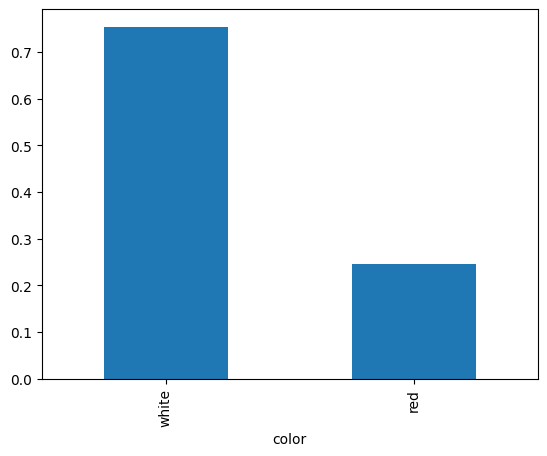

In [28]:
df.color.value_counts(normalize=True).plot.bar()

Class labels to integers

In [29]:
df['color'] = df['color'].replace({'red': 1, 'white': 0}).astype(int)

C:\Users\Florian-Music\AppData\Local\Temp\ipykernel_54052\2345898970.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['color'] = df['color'].replace({'red': 1, 'white': 0}).astype(int)


In [30]:
df.describe().T.drop(columns=['count', '25%', '75%'])

,mean,std,min,50%,max
fixed_acidity,7.215307,1.296434,3.80000,7.00000,15.90000
volatile_acidity,0.339666,0.164636,0.08000,0.29000,1.58000
citric_acid,0.318633,0.145318,0.00000,0.31000,1.66000
residual_sugar,5.443235,4.757804,0.60000,3.00000,65.80000
chlorides,0.056034,0.035034,0.00900,0.04700,0.61100
free_sulfur_dioxide,30.525319,17.749400,1.00000,29.00000,289.00000
total_sulfur_dioxide,115.744574,56.521855,6.00000,118.00000,440.00000
density,0.994697,0.002999,0.98711,0.99489,1.03898
pH,3.218501,0.160787,2.72000,3.21000,4.01000
sulphates,0.531268,0.148806,0.22000,0.51000,2.00000


## Splitting the data 

Since the categories are not evenly distributed, we need to use a stratified splitting approach.

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

target_col = 'color'
feature_cols = df.drop(columns=[target_col]).columns.to_list()

X = df[feature_cols]
y = df[target_col]

sss = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)

train_idx, test_idx = next(sss.split(X, y))

X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

X_test = X.loc[test_idx]
y_test = y.loc[test_idx]

y_train.value_counts(normalize=True).sort_index(), y_test.value_counts(normalize=True).sort_index()

(color
 0    0.753866
 1    0.246134
 Name: proportion, dtype: float64,
 color
 0    0.754
 1    0.246
 Name: proportion, dtype: float64)

So, as we can see, the proportion between classes is maintained through the splits.

## Fitting the model

Now we can take a decision tree classifier and fit it on the data.

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

dt.tree_.node_count, dt.tree_.max_depth

(171, 22)

In [36]:
# The error on the training and test data sets
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,0.999818,0.984000
precision,0.999261,0.963710
recall,1.000000,0.971545
f1,0.999631,0.967611


The prediction is quite good for this model. There is slight overfitting since the performance of the train data is a bit better than the test data, but nothing major on first sight. However, a perfect recall indicates that this problem may be larger than shown here.

## Model selection with grid search

Previously, we just used the default parameters. But there is a large chance another hyperparameter set will perform much better.

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

GR.best_params_

{'max_depth': 7, 'max_features': 9}

The optimum value of '7' for the max depth is already quite different from the '22' from before. It is likely this will improve the overfitting behaviour we saw before.

In [43]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

pd.concat([
        measure_error(y_train, y_train_pred_gr, 'train'),
        measure_error(y_test, y_test_pred_gr, 'test')
    ],
    axis=1
)

,train,test
accuracy,0.995816,0.989000
precision,0.998501,0.983539
recall,0.984479,0.971545
f1,0.991440,0.977505


## Trees as regression

Decision trees can also be used as a regression model. In this case we use the nutritional information to predict the `residual_sugar` value, instead of the recommendation class.

We use the same splits as before. Again, gridsearch is used to find the best parameter values for max_depth and max_features.

In [47]:
target_col = 'residual_sugar'
feature_cols = df.drop(columns=[target_col]).columns.to_list()

X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, target_col]

X_test = df.loc[test_idx, feature_cols]
y_test = df.loc[test_idx, target_col]

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dr = DecisionTreeRegressor().fit(X_train, y_train)

# Base the parameter grid values on the naive fit from above
param_grid = {'max_depth':range(1, dr.tree_.max_depth+1, 2),
              'max_features': range(1, len(dr.feature_importances_)+1)}

GR_sugar = GridSearchCV(DecisionTreeRegressor(random_state=42),
                     param_grid=param_grid,
                     # Maximising *neg* MSE, so minimizing MSE
                     scoring='neg_mean_squared_error',
                      n_jobs=-1)

GR_sugar = GR_sugar.fit(X_train, y_train)

GR_sugar.best_params_

{'max_depth': 25, 'max_features': 10}

In [50]:
from sklearn.metrics import mean_squared_error

y_train_pred_gr_sugar = GR_sugar.predict(X_train)
y_test_pred_gr_sugar  = GR_sugar.predict(X_test)

train_test_gr_sugar_error = pd.Series({'train': mean_squared_error(y_train, y_train_pred_gr_sugar),
                                         'test':  mean_squared_error(y_test, y_test_pred_gr_sugar)},
                                          name='MSE').to_frame().T

train_test_gr_sugar_error

,train,test
MSE,0.00055,2.659874


The Mean Squared Error on the train data is very small, but for the test set it is quite large. Considering that the mean value of 'residual sugar' is 5.443235, having an error of half the mean value is not great. 

We can also plot the predictions versus the actual values:

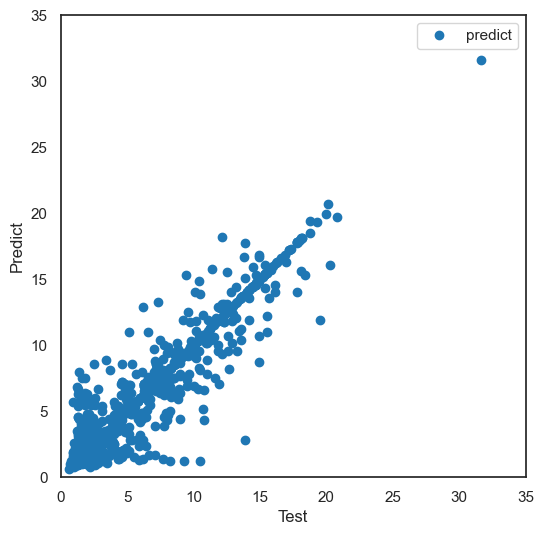

In [51]:
sns.set_context('notebook')
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ph_test_predict = pd.DataFrame({'test':y_test.values,
                                'predict': y_test_pred_gr_sugar}).set_index('test').sort_index()

ph_test_predict.plot(marker='o', ls='', ax=ax)
ax.set(xlabel='Test', ylabel='Predict', xlim=(0,35), ylim=(0,35));

## Showing the Tree

Trees can also be visualised with some useful libraries.

In [ ]:
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [61]:
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = './images/wine_tree.png'
graph.write_png(filename)

True

In [62]:
dot_data = StringIO()

export_graphviz(GR.best_estimator_, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = './images/wine_tree_prune.png'
graph.write_png(filename)

True